In [1]:
%matplotlib inline
import pandas as pd
import re
import seaborn as sns
import csv
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
import patsy
import pickle
import multiprocessing as mp
import numpy as np

from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, LassoCV, RidgeCV, ElasticNetCV, lars_path

from sklearn.preprocessing import StandardScaler, PolynomialFeatures

from sklearn.metrics import r2_score
from sklearn.pipeline import Pipeline

from scipy import stats


In [74]:
all_features = pickle.load(open("all_features.pickle", "rb"))
no_nans = pickle.load(open('no_nan.pickle', 'rb'))

In [75]:
some_features = all_features.drop(columns=['budget', 'runtime_minutes', 'rating_G', 'rating_PG', 'rating_M/PG', 'rating_PG-13', 'rating_R'])
some_features
pickle_out = open("some_features.pickle", 'wb')
pickle.dump(some_features, pickle_out)
pickle_out = open('no_nan.pickle', 'wb')
pickle.dump(no_nans, pickle_out)

In [57]:
X = some_features.drop(columns=['domestic_total_gross'])
y = some_features['domestic_total_gross']

In [58]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state = 420)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=69)

In [59]:
std = StandardScaler()
std.fit(X_train.values)
X_tr = std.transform(X_train.values)
X_te = std.transform(X_test.values)

In [60]:
lasso_model = Lasso(alpha = 1000)
lasso_model.fit(X_train, y_train)
list(zip(X_train.columns, lasso_model.coef_))

[('metascores', -214108.6906521299),
 ('audience_scores', -216866.41904377285),
 ('critic_count', 924622.8932926934),
 ('num_audience_ratings', 64961.576969245536)]

In [61]:
X_train.corr()

,metascores,audience_scores,critic_count,num_audience_ratings
metascores,1.000000,0.751374,0.726448,0.206135
audience_scores,0.751374,1.000000,0.778725,0.266287
critic_count,0.726448,0.778725,1.000000,0.475362
num_audience_ratings,0.206135,0.266287,0.475362,1.000000


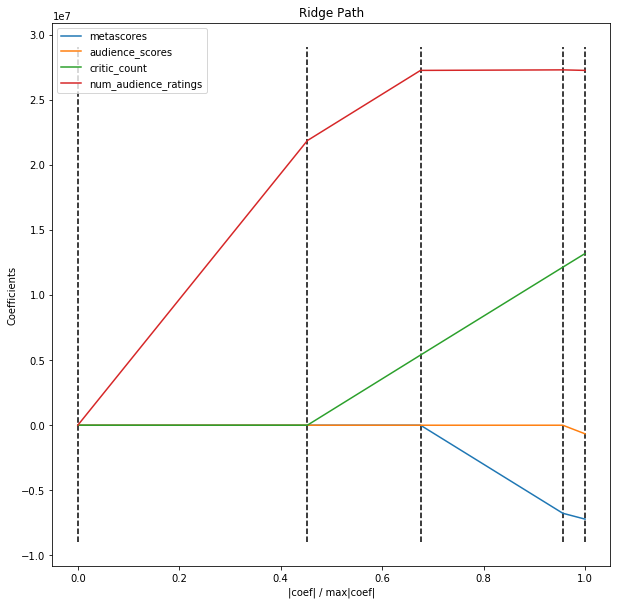

In [72]:
alphas, _, coefs = lars_path(X_tr, y_train.values, method='ridge')

xx = np.sum(np.abs(coefs.T), axis=1)
xx /= xx[-1]

plt.figure(figsize=(10, 10))
plt.plot(xx, coefs.T)
ymin, ymax = plt.ylim()
plt.vlines(xx, ymin, ymax, linestyle='dashed')
plt.xlabel('|coef| / max|coef|')
plt.ylabel('Coefficients')
plt.title('Ridge Path')
plt.axis('tight')
plt.legend(X_train.columns)
plt.show()

In [67]:
alphalist = 10**(np.linspace(-2, 2, 200))
err_vec_val = np.zeros(len(alphalist))
err_vec_train = np.zeros(len(alphalist))

for i, curr_alpha in enumerate(alphalist):
    
    steps = [('standardize', StandardScaler()),
            ('ridge', Ridge(alpha = curr_alpha))]
    
    pipe = Pipeline(steps)
    pipe.fit(X_train.values, y_train)
    
    val_set_pred = pipe.predict(X_val.values)
    err_vec_val[i] = np.mean(np.abs(y_val - val_set_pred))

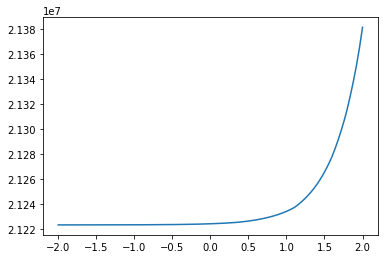

In [68]:
plt.plot(np.log10(alphalist), err_vec_val)

In [69]:
np.min(err_vec_val)

21223073.179967426

In [70]:
alphalist[np.argmin(err_vec_val)]

0.01